# PCA From Scratch

In [3]:
import autoroot
from jaxtyping import Float, Array
import numpy as np
import xarray_einstats
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import xarray as xr
import pandas as pd
import einx
from tqdm.auto import trange, tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.75)


%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [4]:
ds = xr.tutorial.open_dataset("air_temperature")
ds

<xarray.Dataset> Size: 31MB
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float64 31MB ...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [5]:
# change units
# ds = ds.sel(time=slice("2013-01-01", "2013-02-01"))
ds["air"] = ds.air - 273.15

### Rearrange Data

In [6]:
# tranpose
data = ds.transpose("time", "lon", "lat")
data = data.stack(spatial=["lon", "lat"])
data = data.transpose("spatial", "time")

In [7]:
n_space = data.spatial.shape[0]
n_time = data.time.shape[0]

In [8]:
data

<xarray.Dataset> Size: 31MB
Dimensions:  (time: 2920, spatial: 1325)
Coordinates:
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
  * spatial  (spatial) object 11kB MultiIndex
  * lon      (spatial) float32 5kB 200.0 200.0 200.0 200.0 ... 330.0 330.0 330.0
  * lat      (spatial) float32 5kB 75.0 72.5 70.0 67.5 ... 22.5 20.0 17.5 15.0
Data variables:
    air      (spatial, time) float64 31MB -31.95 -31.05 -30.85 ... 22.04 22.54
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

### PCA

In [9]:
X = data.air.values.copy()
n_components = 10

clf = PCA(n_components=n_components, random_state=42)
clf.fit(X=X)

X_red = clf.transform(X)
X_recon = clf.inverse_transform(X_red)

In [10]:
data["air_recon"] = (("spatial", "time" ), X_recon)

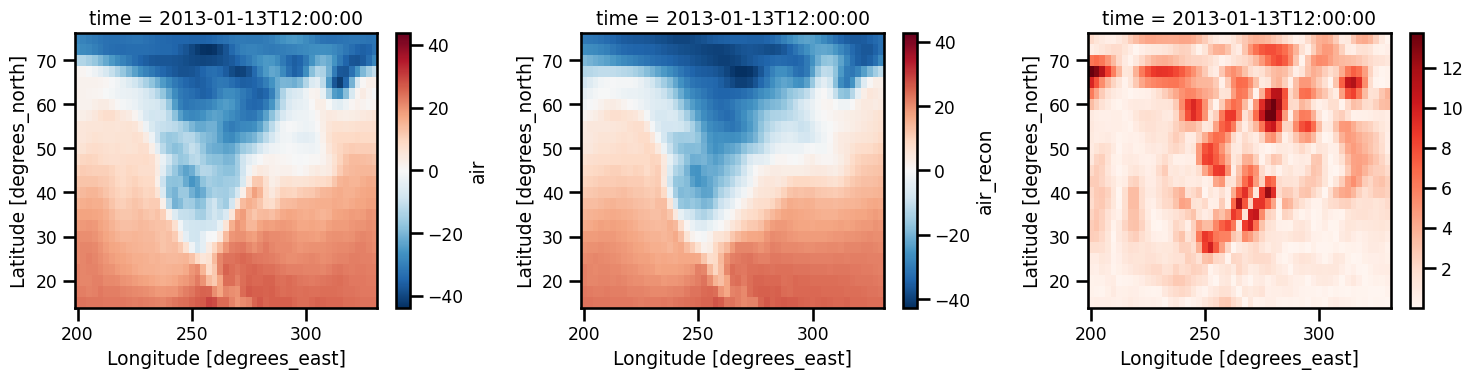

In [11]:
fig, ax = plt.subplots(ncols=3, figsize=(15,4))

itime = 50

data.air.unstack().isel(time=itime).plot.pcolormesh(x="lon", ax=ax[0])
data.air_recon.unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[1])
np.abs(data.air - data.air_recon).unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[2],cmap="Reds")

plt.tight_layout()
plt.show()

### SVD

In [12]:
from typing import NamedTuple

In [13]:
class PCAState(NamedTuple):
    components: np.ndarray
    
def fit_randomize(x, n_components, random_state=123) -> PCAState:
    
    return 
    
def transform(state: PCA, X: np.ndarray) -> np.ndarray:
    return einx.dot("D d, N D -> N d", state.components, X)

def inverse_transform(state: PCA, Z: np.ndarray) -> np.ndarray:
    return einx.dot("D d, N d -> N D", state.components, Z)

def encode_decode(state: PCA, X: np.ndarray) -> np.ndarray:
    return inverse_transform(state, transform(state, X))

In [14]:
from sklearn.utils.extmath import randomized_svd, _randomized_eigsh

In [18]:
# get values
X = data.air.values.copy()

# calculate SVD
U, S, VT = randomized_svd(X, n_components=n_components, random_state=42)

# calculate reconstruction
X_recon = U @ np.diag(S) @ VT

In [19]:
X.shape, U.shape

((1325, 2920), (1325, 10))

In [20]:
# pca_state = PCAState(components=VT.T)

# # reconstruction
# X_recon = encode_decode(pca_state, X)

#### Visualization

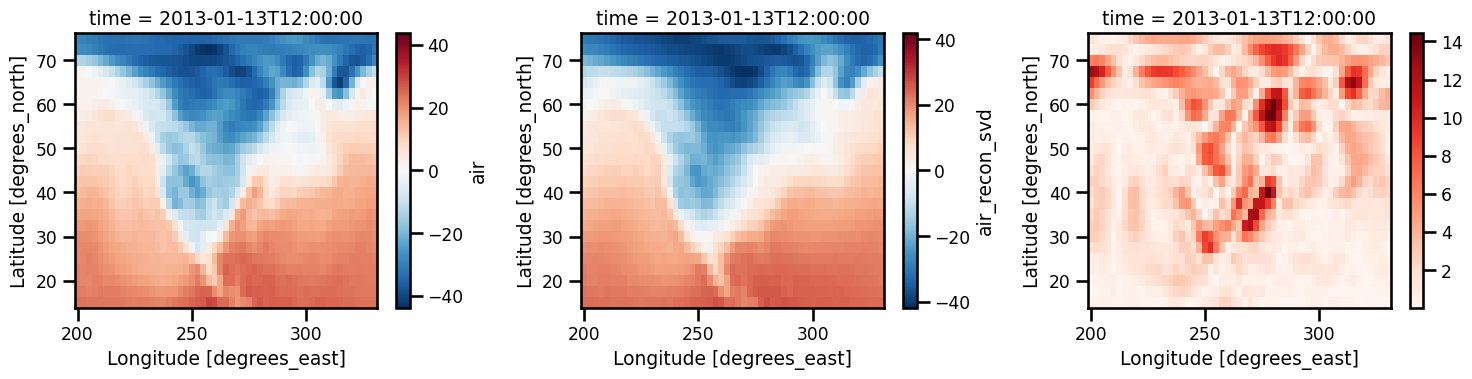

In [21]:
data["air_recon_svd"] = (("spatial", "time" ), X_recon)

fig, ax = plt.subplots(ncols=3, figsize=(15,4))

itime = 50

data.air.unstack().isel(time=itime).plot.pcolormesh(x="lon", ax=ax[0])
data.air_recon_svd.unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[1])
np.abs(data.air - data.air_recon_svd).unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[2],cmap="Reds")

plt.tight_layout()
plt.show()

### EVD - Spatial

This is known as the *snapshot* method.

In [22]:
# get values
X: Float[Array, "Ds Dt"] = data.air.values.copy()

# calculate correlation matrix
C_s: Float[Array, "Ds Ds"] = (X @ X.T) / (n_time - 1)

# calculate EVD
S_s, A_s = _randomized_eigsh(C_s, n_components=n_components, random_state=42)

# spatial coefficients
PHI_s: Float[Array, "Dt d"] = einx.dot("Ds Dt, Ds d -> Dt d", X, A_s)

# reconstruction
X_recon: Float[Array, "Ds Dt"] = einx.dot("Ds d, Dt d -> Ds Dt", A_s, PHI_s)

In [23]:
# pca_state = PCAState(components=U)

# # reconstruction
# X_recon = encode_decode(pca_state, X.T).T

#### Visualization

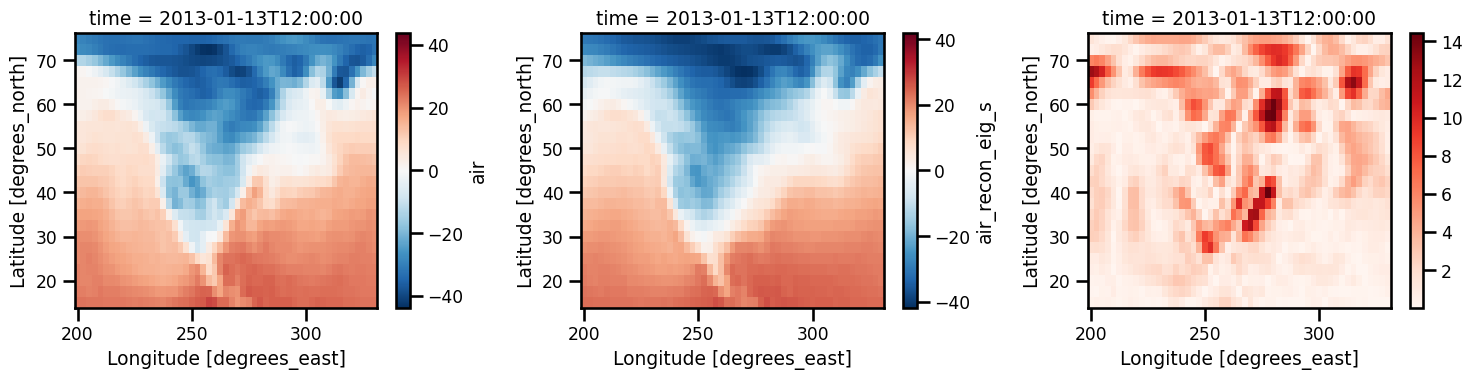

In [24]:
data["air_recon_eig_s"] = (("spatial", "time" ), X_recon)

fig, ax = plt.subplots(ncols=3, figsize=(15,4))

itime = 50

data.air.unstack().isel(time=itime).plot.pcolormesh(x="lon", ax=ax[0])
data.air_recon_eig_s.unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[1])
np.abs(data.air - data.air_recon_eig_s).unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[2],cmap="Reds")

plt.tight_layout()
plt.show()

### EVD - Temporal

In [ ]:
from typing import Optional

def pod_temporal(
    X: np.ndarray, 
    n_components: int=10, 
    random_state: int=42,
    localization: Optional[np.ndarray]=None
) -> np.ndarray:

    n_space, n_time = X.shape

    # calculate covariance
    C_t: Float[Array, "Dt Dt"] = (X.T @ X) / (n_time - 1)

    if localization:
        C_t *= localization

    # calculate EVD
    S, PHI_s = _randomized_eigsh(C_t, n_components=n_components, random_state=random_state)

    # calculate time coefficients
    A_t = einx.dot("Ds Dt, Dt D -> Ds D", X, PHI_s)

    # calculate reconstruction
    X_recon = einx.dot("Ds D, Dt D -> Ds Dt", A_t, PHI_s)

    return X_recon

In [25]:
# get values
X: Float[Array, "Ds Dt"] = data.air.values.copy()

# calculate covariance
C_t: Float[Array, "Dt Dt"] = (X.T @ X) / (n_time - 1)

# calculate EVD
S, PHI_s = _randomized_eigsh(C_t, n_components=n_components, random_state=42)

# time coefficients
A_t = einx.dot("Ds Dt, Dt D -> Ds D", X, PHI_s)

# reconstruction
X_recon = einx.dot("Ds D, Dt D -> Ds Dt", A_t, PHI_s) 

In [26]:
X.shape, PHI_s.shape

((1325, 2920), (2920, 10))

In [22]:
# pca_state = PCAState(components=V)

# # reconstruction
# X_recon = encode_decode(pca_state, X)

#### Visualization

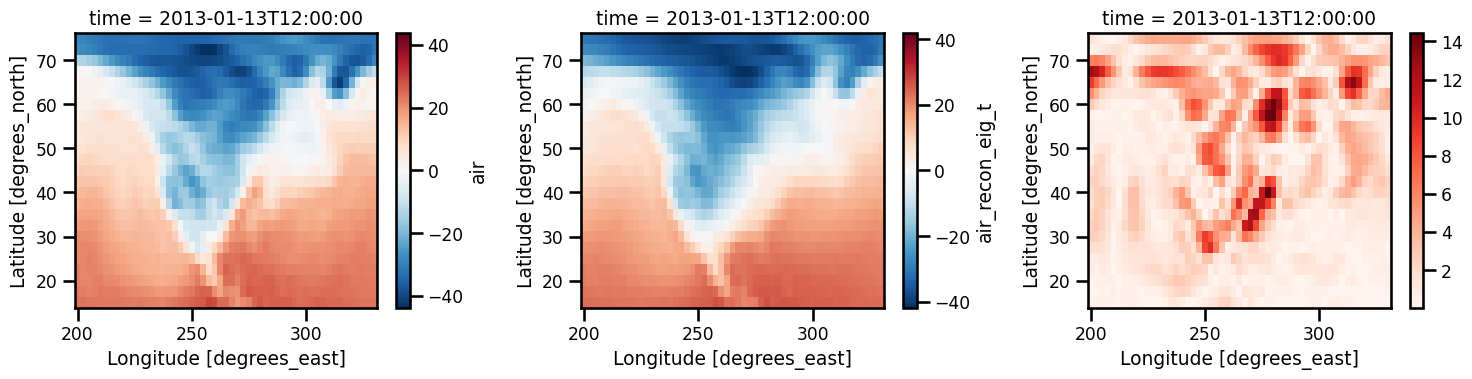

In [23]:
data["air_recon_eig_t"] = (("spatial", "time" ), X_recon)

fig, ax = plt.subplots(ncols=3, figsize=(15,4))

itime = 50

data.air.unstack().isel(time=itime).plot.pcolormesh(x="lon", ax=ax[0])
data.air_recon_eig_t.unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[1])
np.abs(data.air - data.air_recon_eig_t).unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[2],cmap="Reds")

plt.tight_layout()
plt.show()

## Speed Comparison

In [24]:
n_space = 200*200
n_time = 365 * 24

X = np.random.normal(size=(n_space, n_time))


C_t: Float[Array, "Dt Dt"] = (X.T @ X) / (n_time - 1)
C_s: Float[Array, "Ds Ds"] = (X @ X.T) / (n_time - 1)
print(X.shape, C_t.shape, C_s.shape)

(40000, 8760) (8760, 8760) (40000, 40000)


### SVD

In [25]:
%%timeit
_ = randomized_svd(X, n_components=n_components, random_state=42)

1.95 s ± 18.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### EVD - Spatial

In [26]:
%%timeit
_ = _randomized_eigsh(C_s, n_components=n_components, random_state=42)

4.48 s ± 44.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### EVD - Temporal

In [27]:
%%timeit

_ = _randomized_eigsh(C_t, n_components=n_components, random_state=42)

411 ms ± 10.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
